# HW5 Collaboration
```
Class: MACS 30000
Author: Fiona Fan
Date: 2017.11.12
```

## I. Kaggle open call projects (3 points)

### 1. My Kaggle handle is jfan3
### 2. Kaggle Challenge
I'd like to join [BCI Challenge @ NER 2015](https://www.kaggle.com/c/inria-bci-challenge). Even though it is overdue (although it might be reproposed again in the coming years), I am interested in it because I have faith in the future development of Brain-Computer Interface. 

The goal of the challenge is to detect error during an attention-sustained spelling task, using participants' Electroencephalography (EEG) data. A sample trial of each experimental session can be found [here](https://kaggle2.blob.core.windows.net/competitions/kaggle/4043/media/P300_Speller.mp4). The participants' EEG data are recoded by P300 Speller<sup>TM</sup>, which uses a unique EEG signal [P300](https://en.wikipedia.org/wiki/P300_(neuroscience)) to detect select items displayed on a computer screen, via proprietary algorithms. In each trial, after the participant make her selection, a discrete feedback is provided signaling whether she made the right or wrong decision. EEG data can reflect the processing of such feedback by one's brain. The goal of this competition is to use the EEG data to predict whether the participant made an error. The significant of developing a better online error detection and correction can help patients incapcable of movement or vocalization but with full brain function, like Stephen Hawkin, to better express themselves.

The competition requires a Error Potential detection algorithm, capable of detecting the erroneous feedbacks online and to generalize across subjects (transfer learning). My potential approach to this competition can be:
1. Clean up the EEG data
    * Bandpass filer the signals
    * Epoch the signals into intervals determined by the experimental design. Namely the time interval between when the participant is provided feedback, and a little while before she makes the next selection. 
    * Split the data into training set and validation set based on the number of trials.
2. Develop a model that utilizes the epoched EEG signals in the training set as features to predict whether the participant made an error in that epoch. Potential model can be a combination of the following
    * Logistic Regression
    * Neural Net
    * Random Forest
    * [Riemannian Geometry](https://arxiv.org/abs/1310.8115)
    * etc
3. Cross-validate the data on the validation set
    * Use ROC as the performance measure as per Kaggle Competition's requirement.
4. Organize the predicted results into the format required by the Kaggle Competition. 
    * The submission file will be a data file that includes a subject ID and the prediction made by my algorithm, in the following format, as a .csv file:

```
IdFeedBack,Prediction
S01_Sess01_FB001,0.481413
S01_Sess01_FB002,0.95924
S01_Sess01_FB003,0.461558
S01_Sess01_FB004,0.0054562
etc ...
```


### 3. 

The dataset I am using for the problem can be found [here](https://www.kaggle.com/wanghaohan/eeg-brain-wave-for-confusion). The dataset comprises of EEG data measured by Mindset<sup>TM</sup> over the frontal lobe (difference in brain wave voltage between frontal lobe and ear). The data is acquired every 0.5 seconds. During the acquirement of EEG data, 10 recruited college students (mostly Han Chinese) were watching academic course videos (in English with Chinese subtitles), with subject matters ranging from unconfusing ones like introductory algebra or geometry, to confusing ones like quantum mechanics and stem cell research. The videos can be found [here](https://www.kaggle.com/wanghaohan/eeg-brain-wave-for-confusion/data). The goal of the dataset is to use EEG data to predict whether the participant find the video confusing or not.

To characterize the data, I have created a function that can be used to check if an artifact (bogus data that is off threshold) is present in each video trial, and also can plot the mean EEG potentials (red line). The green dotted lines represents the standard deviation of means.

The peak mean voltage of raw data for subject 1 is 104.0mV, and the trough voltage is -42.9mV.
The maximum of averaged potential is 104.0mV, within the threshold 500.


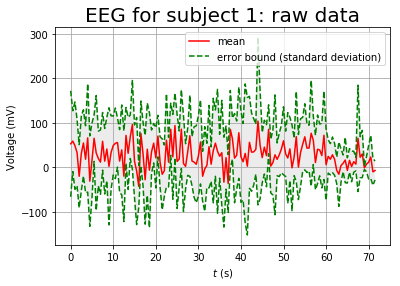

The peak mean voltage of alpha1 data for subject 1 is 140966.0mV, and the trough voltage is 37.4mV.
The maximum of averaged potential is 140966.0mV, which is greater than the threshold 500mV. Check for artifacts.


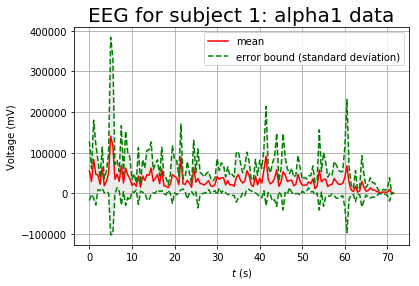

The peak mean voltage of theta data for subject 1 is 360480.0mV, and the trough voltage is 11960.0mV.
The maximum of averaged potential is 360480.0mV, which is greater than the threshold 500mV. Check for artifacts.


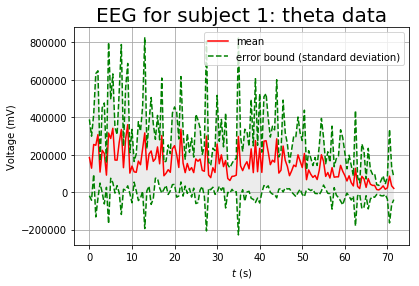

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as itp

# load data into dataframe
df=pd.read_csv('EEG data.csv', header=None)
# rename the dataframe with the proper column names
df.columns = ['Sub_ID', 'Vid_ID', 'attention', 'meditation', 'raw', 'delta', 'theta', 'alpha1', 'alpha2',
             'beta1', 'beta2', 'gamma1', 'gamma2', 'pre_label', 'usr_label']
# correctly format the dataframe into floats
df[['Sub_ID', 'Vid_ID']] = df[['Sub_ID', 'Vid_ID']].apply(pd.to_numeric)

def plot_subject (df, sub_ID, freq, thresh):
    '''
    This function plots the EEG potential averaged over all video trials for each subject. It prints out the peak
    and trough potential values. This function can be used to detect artifacts.
    :param df: the accepted dataframe
    :param sub_ID: The subject's ID, ranging from 1~10
    :param freq: The form of data, drawing from ['raw', 'delta', 'theta', 'alpha1', 'alpha2',
             'beta1', 'beta2', 'gamma1', 'gamma2']
    :return: None
    '''
    # filtered dataframe for the specific subject
    df_ID = df [df['Sub_ID'] == sub_ID-1]
    # get video its as a set
    vid_ID_set = {int(x) for x in set (df_ID['Vid_ID'])}
    # get the sizes of recorded EEG data for each video trial
    sizes = np.zeros (len(vid_ID_set))
#     print (f'vid_ID_set:{vid_ID_set}')
    for ID in vid_ID_set:
        sizes[ID] = np.size(df_ID[df_ID.Vid_ID == ID].Sub_ID)
    sizes.astype(int)
#     print (f'sizes:{np.max(sizes)}')
    
    # create a dataset for all EEG data and all video trials
    data_mat = np.zeros ((int(np.max(sizes)), len(vid_ID_set)))
    #populate the dataset with the designated EEG data
    for ID in vid_ID_set:
        data_mat[:int(sizes[ID]), ID] = df_ID.loc[df_ID.Vid_ID==ID, freq]

    to_plot_mean = np.mean(data_mat, axis=1)
    errors = np.std(data_mat, axis=1)
    
    
    peak = np.max(to_plot_mean)
    trough = np.min(to_plot_mean)
    
    print (f'The peak mean voltage of {freq} data for subject {sub_ID} is {peak}mV, and the trough voltage is {trough}mV.')
    
    # check if there is need for eliminating artifact.
    if np.max(to_plot_mean)>thresh:
        print (f'The maximum of averaged potential is {np.max(to_plot_mean)}mV, which is greater than the threshold {thresh}mV. Check for artifacts.')
    else:
        print (f'The maximum of averaged potential is {np.max(to_plot_mean)}mV, within the threshold {thresh}.')
    
    # fit smooth lines for mean and upper and lower bounds of the mean EEG data
    xvec = np.arange (len(to_plot_mean)) * 0.5
    f = itp.interp1d(xvec, to_plot_mean)
    f_plus = itp.interp1d(xvec, to_plot_mean+errors)
    f_minus = itp.interp1d(xvec, to_plot_mean-errors)
    inter = f(xvec)
    inter_plus = f_plus(xvec)
    inter_minus = f_minus(xvec)
    
    #plotting
    fig, ax = plt.subplots()
    ax.plot(xvec, inter, 'r-', label = "mean")
    ax.plot(xvec, inter_plus, 'g--', label = "error bound (standard deviation)")
    ax.plot(xvec, inter_minus, 'g--')
    ax.fill_between(xvec, inter_plus, inter_minus, facecolor="gray", alpha=0.15)
#     plt.plot(x_vec, y_vec)
    plt.title(f'EEG for subject {sub_ID}: {freq} data', fontsize=20)
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.xlabel(r'$t$ (s)')
    plt.ylabel('Voltage (mV)')
    plt.legend()
    plt.show()

plot_subject (df, 1, 'raw', 500)
plot_subject (df, 1, 'alpha1', 500)
plot_subject (df, 1, 'theta', 500)


## II. Improving a journal article (3 points)

The article I am using is name [Recovering Human Body Configurations: Combining Segmentation and Recognition](http://ieeexplore.ieee.org/document/1315182/). This is a well-cited paper that introduced a new algorithm which can detect a human figure, recognize her limbs and joints, and also detect the associated pixel masks. For a brief description of their model, the algorithm first take the input image apart into superpixels (a huge number of discontinuous small regions), and large continuous regions, which can potentially be limbs and torsos. They then use a combination of cues, like contour, shape, shading and focus cues to detect limbs and torsos. The shortlisted limb and torso condidates are then further pruned given global constraints such as relative scale and symmetry in clothing. Finally, they conduct a combinational search in all the superpixels to recover the true form of the limbs and torsos. 

For the construction of their limb/half-limb detectors, the authors first trained their algorithm with some hand-labeled limbs, as shown in [Figure 5](#fig5). For evaluation of their limb/half-limb detectors, as well as the efficiency of the cues being used, the authors used the other hand-labeled images (validation set) for their classification performance. [Figure 6](#fig6) of the article evaluates the cues used for half-limb detection, using the true positive number of detection (y axis) as the metric. 

Similarly, the authors also labeled joint positions. They split the image dataset into training set and validation set, and trained both their algorithm and a previously established Examplar-based detector used as a benchmark to beat. [Figure 8](#fig8) shows the performance of the torso finders. The authors' algorithm beat the benchmark by a fair margin. However, in their discussion, the authors admitted that the outperformance might be the limited amount of training data. 

The paper was pulished in 2004 (Benjamin agreed on it being 'recent'), before the advent of MTurk, and has since gained 623 citations. The algorithm has proved its worth over time. In the paper, the authors used hand-labeled images of baseball players scouraged from the Internet sports news. The hand-labeled nature of the images limited the dataset to be only 62 in size. This could lead to insufficient calibration of algorithms, and underrated performance of the proposed or benchmark algorithm.

One way to improve is to design two groups of HITs on MTurk. For both of the HITs, only workers with a higher than 90% HIT approval rate will be recruited. 

The first group of HITs recruits participants to upload images that they can find on the internet, or private ones, with full human bodies in them. For each HIT in the group, the participant will be asked to upload 5 images, and the task will approximately take 10 minutes for a reward of $0.05-0.1. Incoming images will run through an automatic check in the database to see if an identical one already exists via simple identification algorithm. If the incoming image pass the screening test, it will be passed to the second group of HITs.

The second group of HITs recruits people to hand label the limbs, joints and torsos separately. Before that, the participants will identify whether a full body appears in the image. If not, the image will be discarded. For each HIT in the group, the participant will be asked to hand label 5 images, and the task will approximately take 10 minutes for a reward of $0.05-0.1. A random selection of the completed HITs will be verified by the researchers to check for accuracy. 

By turining the data collection process into a computational human part, the researchers can calibrate their model on a dataset of much larger magnitude, and outside of the scope of simply sports news baseball players. To get a dataset of size 10000, the budget is around will be well below $3000, assuming 1 in 3 uploaded images is kept. Doing so will increase the validity of the paper by presenting a well calibrated model with trustworthy benchmark algorithms. 




**<a name = "fig5"></a>Figure 5. Hand-segmented limbs for training**
![See figure5.png](figure5.png)

**<a name = "fig6"></a>Figure 6. Evaluating half-limb cues**
![See figure6.png](figure6.png)



**<a name = "fig8"></a>Figure 8. Evaluating torso finders**
![See figure8.png](figure8.png)





## III. MTurk

***I mainly chose to work on non-paying HITs for legal reasons.***

[My Account](myaccount.png)

[Assigned Qulification Page](qualifications_assigned.png)
[Pending Qulification Page](qualifications_pending.png)

![See myaccount.png](myaccount.png)
![See qualifications_assigned.png](qualifications_assigned.png)
![See qualifications_pending.png](qualifications_pending.png)